In [117]:
import pandas as pd
import json
import glob

# Load the JSON file
# Read all JSON files that start with "perplexity_"
json_files = glob.glob('../perplexity_*.json')

# Combine data from all JSON files
data = []
for file in json_files:
    with open(file, 'r') as f:
        data.extend(json.load(f))

# Create a DataFrame
df = pd.DataFrame(data)

# Display the head of the DataFrame
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286
...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175


In [118]:
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286
...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175


In [119]:
# Extract the .../prompts_Z/.../PX_Y.txt part and create columns for X, Y, and Z
df[['Z', 'X', 'Y']] = df['file'].str.extract(r'-(\w+)_P(\d+)_(\d+)\.txt')

# Convert X and Y to integers for consistency
df['X'] = df['X'].astype(int)
df['Y'] = df['Y'].astype(int)

# Display the updated DataFrame
df

,file,longest_low_perplexity_text,longest_low_perplexity_length,token_count,avg_perplexity,Z,X,Y
0,outputs/perplexity/prompts_morphine/pythia-2.8...,scheme (C): \nAs shown in the reaction formul...,21,21,17.557059,no_prefix,0,0
1,outputs/perplexity/prompts_morphine/pythia-2.8...,processing power.\n\n2),7,7,32.912803,no_prefix,1,0
2,outputs/perplexity/prompts_morphine/pythia-2.8...,"back to room temperature,",5,5,60.026881,no_prefix,2,0
3,outputs/perplexity/prompts_morphine/pythia-2.8...,choices.\n\n**Step 2:**,8,8,38.641155,no_prefix,3,0
4,outputs/perplexity/prompts_morphine/pythia-2.8...,_Papaver somniferum_,9,9,40.124286,no_prefix,4,0
...,...,...,...,...,...,...,...,...
625,outputs/perplexity/prompts_morphine/pythia-2.8...,"_Papaver somniferum_ ,",10,10,43.680254,wikipedia,20,3
626,outputs/perplexity/prompts_morphine/pythia-2.8...,raw opium is,4,4,41.338655,wikipedia,20,4
627,outputs/perplexity/prompts_morphine/pythia-2.8...,methadone hydrochloride,5,5,32.687291,wikipedia,20,5
628,outputs/perplexity/prompts_morphine/pythia-2.8...,"reduction of 2,5-dimethylmorphinone",11,11,36.446175,wikipedia,20,6


In [166]:
import plotly.express as px

# Create a boxplot for 'longest_low_perplexity_length' grouped by 'Z'
fig = px.box(df, x='Z', y='avg_perplexity', 
             title='Distribution of Longest Low Perplexity Length by Prefix Type',
             labels={'avg_perplexity': 'Average perplexity', 'Z': 'Prefix Type'})

# Update layout
fig.update_layout(
    title='Average Perplexity per prefix',
    xaxis_title='Prefix',
    yaxis_title='Average Perplexity',
    barmode='group',  # Group bars by X value
    legend_title='Prefix type'
)

In [167]:
import plotly.express as px

# Create a boxplot for 'longest_low_perplexity_length' grouped by 'Z'
fig = px.box(df, x='Z', y='longest_low_perplexity_length', 
             title='Distribution of Longest Low Perplexity Length by Prefix Type',
             labels={'longest_low_perplexity_length': 'Longest Low Perplexity Length', 'Z': 'Prefix Type'})

# Update layout
fig.update_layout(
    title='Longest low-perplexity length per prefix',
    xaxis_title='Prefix',
    yaxis_title='Longest low perplexity',
    barmode='group',  # Group bars by X value
    legend_title='Prefix type'
)

fig.update_xaxes(tickvals=grouped['Z'], ticktext=["According to literature, ...", "No prefixes", "According to Wikipedia, ..."])

fig.show()

(array([125.,  78.,   3.,   0.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([ 17.5570592 ,  48.85453634,  80.15201348, 111.44949062,
        142.74696777, 174.04444491, 205.34192205, 236.63939919,
        267.93687633, 299.23435347, 330.53183061]),
 <BarContainer object of 10 artists>)

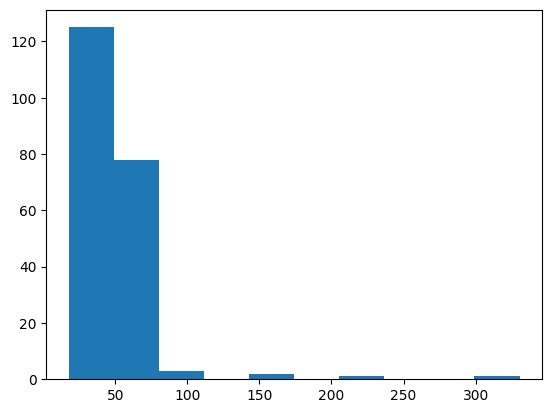

In [139]:
import matplotlib.pyplot as plt

import plotly.express as px

# Create a histogram for each value of Z
fig = px.histogram(df, x='avg_perplexity', color='Z', barmode='overlay', 
                   title='Distribution of Average Perplexity by Z',
                   labels={'avg_perplexity': 'Average Perplexity', 'Z': 'Prefix Type'})

# Show the plot
fig.show()

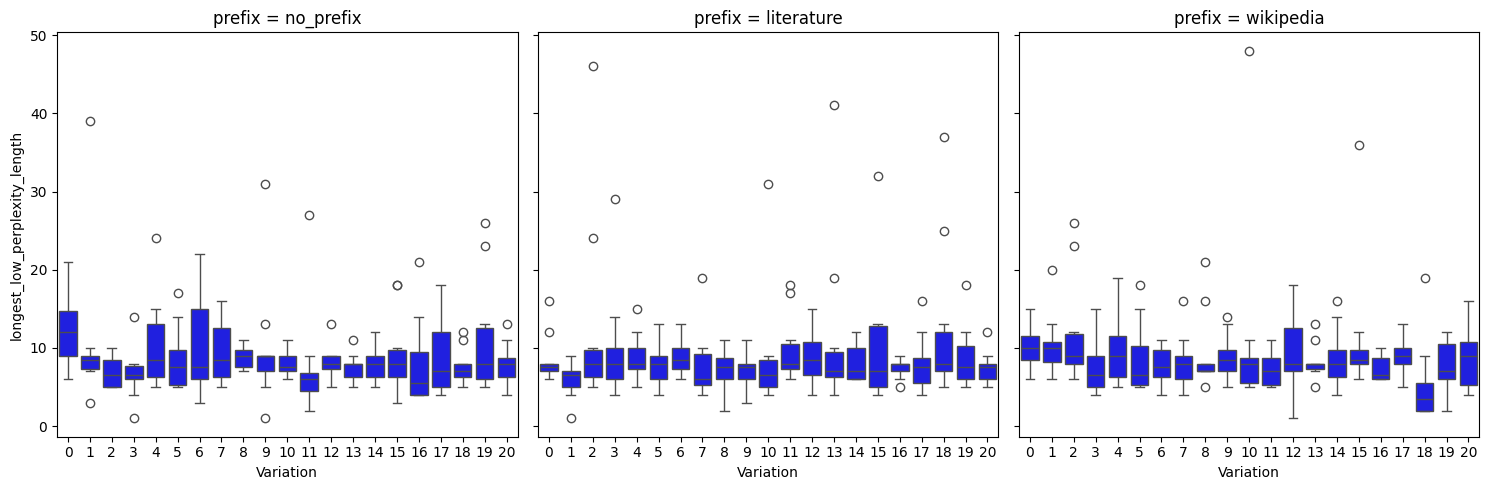

In [174]:
# Create subplots for each value of Z
fig, axes = plt.subplots(1, len(unique_z_values), figsize=(15, 5), sharey=True)

per = 'longest_low_perplexity_length' #longest_low_perplexity_length

for ax, z_value in zip(axes, unique_z_values):
    # Filter data for the current Z value
    z_data = df[df['Z'] == z_value]
    
    # Create a boxplot
    sns.boxplot(data=z_data, x='X', y=per, ax=ax, color='blue')
    
    # Add labels and title
    ax.set_title(f'prefix = {z_value}')
    ax.set_xlabel('Variation')
    ax.set_ylabel(per)

plt.tight_layout()
plt.show()


In [160]:
df.sort_values(by='longest_low_perplexity_length', ascending=False).iloc[0, 0]

'outputs/perplexity/prompts_morphine/pythia-2.8b-wikipedia_P10_1.txt'

Successfully extracted 95 infinigram_count values


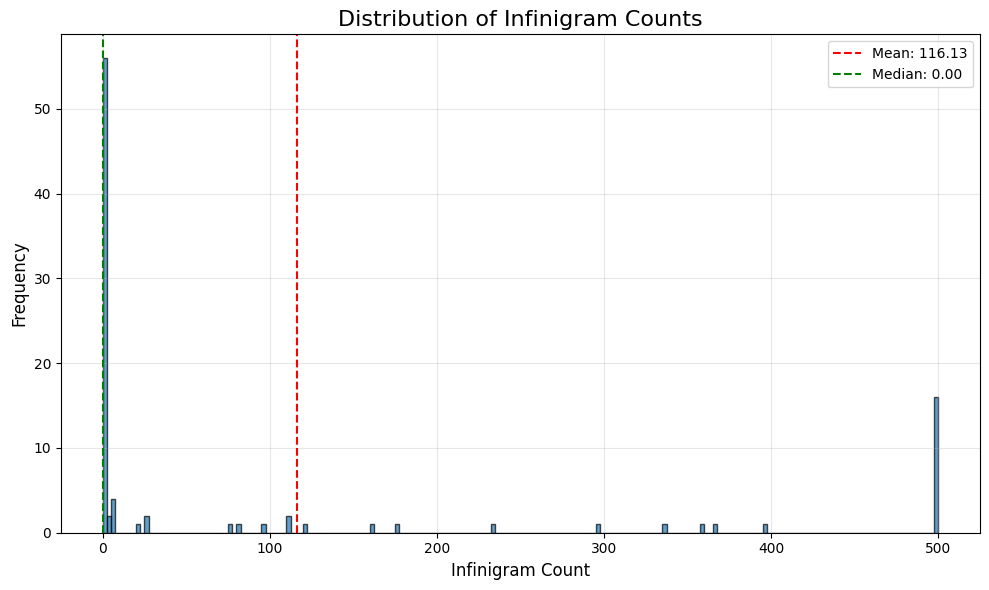


Infinigram Count Statistics:
Total samples: 95
Mean: 116.13
Median: 0.00
Standard deviation: 192.37
Min: 0
Max: 500


TypeError: Series.count() takes 1 positional argument but 2 were given

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Function to load the JSON file and extract infinigram_count values
def load_and_extract_infinigram_counts(json_file_path):
    """
    Load a JSON file and extract all infinigram_count values from the data.
    
    Parameters:
    -----------
    json_file_path : str
        Path to the JSON file containing the data
        
    Returns:
    --------
    list
        List of infinigram_count values
    """
    try:
        # Load the JSON file
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Extract infinigram_count values
        infinigram_counts = [item['infinigram_count'] for item in data]
        
        print(f"Successfully extracted {len(infinigram_counts)} infinigram_count values")
        return infinigram_counts
    
    except FileNotFoundError:
        print(f"Error: File '{json_file_path}' not found.")
        return []
    except json.JSONDecodeError:
        print(f"Error: '{json_file_path}' is not a valid JSON file.")
        return []
    except KeyError:
        print(f"Error: 'infinigram_count' key not found in some items.")
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []

# Function to plot the histogram
def plot_infinigram_count_histogram(infinigram_counts):
    """
    Create a histogram of infinigram_count values.
    
    Parameters:
    -----------
    infinigram_counts : list
        List of infinigram_count values
    """
    if not infinigram_counts:
        print("No data to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    
    infinigram_counts = pd.Series(infinigram_counts)
    infinigram_counts = infinigram_counts[infinigram_counts > 0]  # Filter out zero values
    infinigram_counts[infinigram_counts > 500] = 500  # Cap values at 1000 for better visualization
    
    # Create histogram
    n, bins, patches = plt.hist(infinigram_counts, bins=200, edgecolor='black', alpha=0.7)
    # Add mean line
    mean_value = np.mean(infinigram_counts)
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                label=f'Mean: {mean_value:.2f}')
    
    # Add median line
    median_value = np.median(infinigram_counts)
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                label=f'Median: {median_value:.2f}')
    
    # Add styling
    plt.title('Distribution of Infinigram Counts', fontsize=16)
    plt.xlabel('Infinigram Count', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\nInfinigram Count Statistics:")
    print(f"Total samples: {len(infinigram_counts)}")
    print(f"Mean: {mean_value:.2f}")
    print(f"Median: {median_value:.2f}")
    print(f"Standard deviation: {np.std(infinigram_counts):.2f}")
    print(f"Min: {min(infinigram_counts)}")
    print(f"Max: {max(infinigram_counts)}")
    
    # Show percentage of zeros
    zero_count = infinigram_counts.count(0)
    zero_percentage = (zero_count / len(infinigram_counts)) * 100
    print(f"Number of zeros: {zero_count} ({zero_percentage:.2f}%)")

# Path to your JSON file
json_file_path = '../perplexity_results_math_with_counts.json'  # Replace with actual path

# Load data and extract infinigram counts
infinigram_counts = load_and_extract_infinigram_counts(json_file_path)

# Plot histogram
if infinigram_counts:
    plot_infinigram_count_histogram(infinigram_counts)